In [1]:
# RelaxationTestJ
# Created to test the relaxation method and various features of NumPy. Jupyter Notebook Version
# made by Masen Pitts
# Updated 11/22/2021

import time
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

#work on: look at endpoints a bit more
#         add variables: xMesh, yMesh, zMesh, xSize, ySize, zSize
#         


# Addressing Possible Ambiguities in Comments:
# - "Boundary of the region" refers to the actual ends of the 3D mesh grid
# and not the points within the region that are given pre-determined values.
# - "Not Free Points" refers to points both on the boundary and within the boundary
# at which the value of the potential is pre-determined.


meshResolution = 40 # Gives the number of mesh points extending in each direction;
                    # each spatial axis has points defined on [0, meshResolution]
                    # (unless it is indicated otherwise)
 
# Function that sets the potential value of the mesh points on the boundary of the region and marks them
# as not free.
# Expected Parameters:
#   potential - A 3D NumPy Array of floating point values
#   freePoints - A 3D NumPy Array of boolean values
#   boundaryValue - A floating point or integer value specifying the desired value
#   of the potential at the boundary of the region
#**NOTE: This function expects "potential" and "freePoints" to be the same shape!**
def setBoundaries(potential, freePoints, boundaryValue):
    # Prints an error message and ends the program if the arrays passed to the function are not the same shape
    if potential.shape != freePoints.shape:
        print("Error: The array passed for the potential must be the same shape as the array passed for freePoints!")
        print("Check the shapes of the arrays being passed to the \"setBoundaries\" function")
        quit()   
    # Variables that store the values of the non-zero ends of the region boundary
    global xEnd, yEnd, zEnd
    xEnd = potential.shape[0]
    yEnd = potential.shape[1]
    zEnd = potential.shape[2]
    
    # Iterates through every mesh point on the boundary of the region, setting the potential
    # at these points equal to the given value and marking the points as not free
    for y in range(yEnd):
        for z in range(zEnd):
            potential[0, y, z] = boundaryValue
            potential[xEnd-1, y, z] = boundaryValue
            freePoints[0, y, z] = False
            freePoints[xEnd-1, y, z] = False
    for x in range(xEnd):
        for z in range(zEnd):
            potential[x, 0, z] = boundaryValue
            potential[x, yEnd-1, z] = boundaryValue
            freePoints[x, 0, z] = False
            freePoints[x, yEnd-1, z] = False
    for x in range(xEnd):
        for y in range(yEnd):
            potential[x, y, 0] = boundaryValue
            potential[x, y, zEnd-1] = boundaryValue
            freePoints[x, y, 0] = False
            freePoints[x, y, zEnd-1] = False

# Function that implements the relaxation method for a given 3D mesh grid to calculate the electrostatic
# potential at each free point on the grid.
# Expected Parameters:
#   p - A 3D NumPy Array of floating point values representing the "potential" array
#   freePoints - A 3D NumPy Array of boolean values
#   tolerance - A floating point number that specifies how accurate the relaxation should
#   be and hence how long the method should run. The process will stop once the largest change
#   in a potential value between any two iterations is less than "tolerance."
#   relaxFactor - A floating point number or integer that allows for over-relaxation to be used 
#   if desired. 
#       relaxFactor = 1: Normal relaxation method implemented
#       relaxFactor > 1: Over-relaxation occcurs
#   Values between 1 and 2 should be used since a value of 2 or greater makes the method unstable. 
#   Values in the range of 1.5-1.8 seem to be the fastest. This may change based on the value of 
#   meshResolution and can vary with given problem conditions
def relaxation(p, freePoints, tolerance, relaxFactor):
    
    dVmax = 100 # Keeps track of the largest change in potential value between the previous iterations
                # and the current one.
    n=0 # Counts the total number of iterations the while loop makes (for use see commented out code below)
    while dVmax > tolerance:
        dVmax = 0
        for x in range(xEnd):
            for y in range(yEnd):
                for z in range(zEnd):
                    if freePoints[x, y, z]:
                        oldV = p[x, y, z] # Store the old potential value at this point
                        # Calculate the new potential at this point by taking the average of the potential
                        # values of all adjacent points.
                        newV = (1/6)*(p[x+1,y,z]+p[x-1,y,z]+p[x,y+1,z]+p[x,y-1,z]+p[x,y,z+1]+p[x,y,z-1])
                        dV = newV - oldV    # Store the change in potential value between iterations
                        # Checks for new dVmax
                        if abs(dV) > dVmax:
                            dVmax = abs(dV)
                        p[x, y, z] = oldV + dV*relaxFactor
        n+=1           # This commented out code can be used to test values of relaxFactor; the code will 
        print(dVmax)   # print the total number of times the relaxation method iterates and will print the
    print(n)           # value of dVmax calculated during each iteration. Printing the value of dVmax allows
                        # the user to determine whether the algorithm is converging.
    
    
'''    
def testMethod(potential):
    potentialCopy = potential
    for y in range(potential.shape[1]):
        yd = y*d
        for z in range(potential.shape[2]):
            potentialCopy[0, y, z] = yd*z*d
'''

# Rectangular Metal Pipe
# Compare to: Infinitely Long Rectangular Metal Pipe (Griffiths Chapter 3, Example 5)
#******************************************************************************
xFactor = 5 # Determines the length of the pipe in the x direction as a multiple
            # of the width of the pipe
            
# Variables that determine the rectangular bounds of the region
# in Cartesian Coordinates
ySize = 5
zSize = ySize
xSize = xFactor*ySize

# Variables stored for convience for initializing the arrays and performing
# iterative calculations on the mesh points
yMesh = meshResolution + 1
zMesh = yMesh
xMesh = xFactor*meshResolution + 1

# Variable that stores the actual space between each of the mesh points
d = ySize/meshResolution

# Initializes a 3D NumPy array of float values with a shape determined by the x/y/zMesh variables;
# Used to store calculated values of the electrostatic potential at each mesh point
potential = np.full((xMesh, yMesh, zMesh), 0, dtype=np.float64)

# Initializes a 3D NumPy array of boolean values with the same shape as the "potential" array;
# Used to determine which mesh points are "free." Free mesh points are points where the potential
# is to be determined. Points that are not free are those that are given fixed values in the set-up
# of the model.
freePoints = np.full((xMesh, yMesh, zMesh), True, dtype=np.bool_)

setBoundaries(potential, freePoints, 0)

# Sets the values of the potential on the x = 0 face of the pipe
for y in range(yMesh):
    yd = y*d
    for z in range(zMesh):
        potential[0, y, z] = yd*z*d
        freePoints[0, y, z] = False 

start = time.time()
relaxation(potential, freePoints, 0.01, 1.8)
print(time.time() - start)
#******************************************************************************

9.52880859375
8.422481881632333
4.955515023359821
3.060186254596993
1.9305725515314496
1.347909700275989
1.1698789645998793
0.900178502364759
0.7291428312839789
0.5814943142679465
0.49273748622917646
0.3927274280698372
0.32747716440522545
0.2652414901906308
0.22410557238089135
0.1825587692854138
0.15390121482437236
0.12675513672123317
0.10754912003604211
0.08934856043428097
0.07605045467183302
0.06386334646025293
0.05469143386274178
0.04643542484667762
0.0401362265762053
0.03438351325629618
0.03005931916304272
0.02596809853911708
0.022969416718235713
0.020012517488287918
0.01790856227649451
0.015787241811078045
0.014232649091964866
0.012718694864193969
0.011527724047590837
0.010405143234305081
0.009525713799943603
37
72.72586798667908


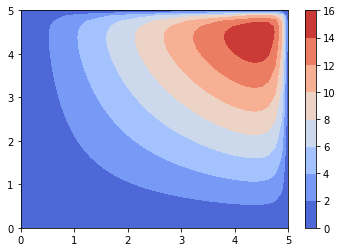

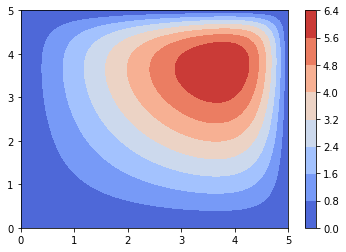

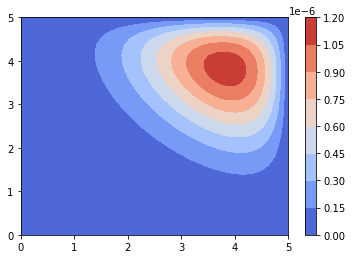

In [8]:
 
# print statements testing the values of array attributes and array entries
#print(potential[0])
#print("\n\n\n")
#print(potentialCopy[0])

'''
print(potential[0])
print("\n\n\n")
print(potential[xMesh-1])
print("\n\n\n")
print(potential[2])

print(potential.ndim)
print(potential.size)
print(potential.shape)
'''

y = np.linspace(0, ySize, yMesh)
z = np.linspace(0, zSize, zMesh)
#Y, Z = np.meshgrid(y, z)
V1 = potential[1]
V2 = potential[6]
V3 = potential[int(xMesh/2)]

plt.figure(1)
plt.contourf(y, z, V1, cmap=cm.coolwarm)
plt.colorbar()

plt.figure(2)
plt.contourf(y, z, V2, cmap=cm.coolwarm)
plt.colorbar()

plt.figure(3)
plt.contourf(y, z, V3, cmap=cm.coolwarm)
plt.colorbar()

plt.show()